# Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil

# Intro
The goal of this project is to explore differences in claim patterns of fraudulent medical providers vs non fraudulent medical providers and to create a ml model capable of predict if a transaction was made by a potentially fraudulent medical provider.

# Importing data

In [2]:
train_in_df = pd.read_csv('data/Train_Inpatientdata-1542865627584.csv') # Hospitalized claims
train_out_df = pd.read_csv('data/Train_Outpatientdata-1542865627584.csv') # Not Hospitalized claims
train_benef_df = pd.read_csv('data/Train_Beneficiarydata-1542865627584.csv') # Patient information
target_df = pd.read_csv('data/Train-1542865627584.csv') # Targets

In [3]:
print(f'train_in_df shape: {train_in_df.shape}')
print(f'train_out_df shape: {train_out_df.shape}')
print(f'train_benef_df shape: {train_benef_df.shape}')
print(f'Target_df shape: {target_df.shape}')

train_in_df shape: (40474, 30)
train_out_df shape: (517737, 27)
train_benef_df shape: (138556, 25)
Target_df shape: (5410, 2)


## Merging data frames and justification

### train_in_df & train_out_df

train_in_df contains data of those claims that required hospitalisation and train_out_df claims that didn´t. There are three columns in train_in_df that are not present in train_out_df:

<img src="data/health_fraud.png" width="1000" height="900" align="center">

In [4]:
# Columns only in train_in_df
[l for l in train_in_df.columns if l not in train_out_df.columns]

['AdmissionDt', 'DischargeDt', 'DiagnosisGroupCode']

It makes sense that AdmissionDt (Admission date) and DischargeDt (Discharge date) are only present in those claims that required hospitalisation. DiagnosisGroupCode must be a group assigned by the hospital to the hospitalized beneficiary.

To append both datasets and be able to easily identify if the patient was hospitalized we will create an extra boolean column in both datasets called 'hospitalized' before.

In [5]:
train_in_df['hospitalized'] = 1
train_out_df['hospitalized'] = 0

train_df = pd.concat([train_in_df, train_out_df])

print(f'train_df shape: {train_df.shape}')

train_df shape: (558211, 31)


### train_benef_df

Beneficiary data will be merged on 'BeneID' column. 

In [6]:
train_df = train_df.merge(train_benef_df, on='BeneID', how='left')
print(f'train_df shape: {train_df.shape}')

train_df shape: (558211, 55)


### target_df
Target column will be added merging train_df with target_df on 'Provider' column.

In [7]:
train_df = train_df.merge(target_df, on='Provider', how='left')
print(f'train_df shape: {train_df.shape}')

train_df shape: (558211, 56)


Finally we will check for duplicates and if there are remove them

In [8]:
if train_df.drop_duplicates().shape[0] == train_df.shape[0]:
    print('No duplicates found')
else:
    train_df.drop_duplicates(inplace=True)

No duplicates found


In [9]:
del target_df, train_benef_df, train_in_df, train_out_df # deleting all data frames to free some space

# EDA

## Var types

In [10]:
num_vars = ['InscClaimAmtReimbursed', 'DeductibleAmtPaid', 'NoOfMonths_PartACov', 'NoOfMonths_PartBCov',  'IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt', 
            'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt']

bool_vars = ['hospitalized', 'RenalDiseaseIndicator', 'PotentialFraud', 'ChronicCond_Alzheimer', 'ChronicCond_Heartfailure', 'ChronicCond_KidneyDisease',
            'ChronicCond_Cancer', 'ChronicCond_ObstrPulmonary', 'ChronicCond_Depression', 'ChronicCond_Diabetes', 'ChronicCond_IschemicHeart', 'ChronicCond_Osteoporasis',
            'ChronicCond_rheumatoidarthritis', 'ChronicCond_stroke']

date_vars = ['ClaimStartDt', 'ClaimEndDt', 'AdmissionDt', 'DischargeDt', 'DOB', 'DOD']

cat_vars = ['BeneID', 'ClaimID', 'Provider', 'AttendingPhysician', 'OperatingPhysician', 'OtherPhysician', 'ClmAdmitDiagnosisCode', 'DiagnosisGroupCode', 'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2',
            'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6','ClmDiagnosisCode_7', 'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9','ClmDiagnosisCode_10',
            'ClmProcedureCode_1', 'ClmProcedureCode_2', 'ClmProcedureCode_3', 'ClmProcedureCode_4', 'ClmProcedureCode_5', 'ClmProcedureCode_6', 'Gender', 'Race', 'State', 'County']

Properly casting variables

In [11]:
from cmath import nan

train_df[num_vars] = train_df[num_vars].apply(pd.to_numeric, errors='coerce')
train_df[date_vars] = train_df[date_vars].apply(pd.to_datetime, errors='coerce')
train_df[cat_vars] = train_df[cat_vars].astype('str')
train_df.replace('nan', nan, inplace=True) # Replacing 'nan' string values for NaN


We can see that there is not an uniform way of writting theese boolena variables. we will convert them all to True/False.

In [12]:
for var in bool_vars:
    print(var)
    print(train_df[var].unique())

hospitalized
[1 0]
RenalDiseaseIndicator
['0' 'Y']
PotentialFraud
['Yes' 'No']
ChronicCond_Alzheimer
[1 2]
ChronicCond_Heartfailure
[2 1]
ChronicCond_KidneyDisease
[1 2]
ChronicCond_Cancer
[2 1]
ChronicCond_ObstrPulmonary
[2 1]
ChronicCond_Depression
[1 2]
ChronicCond_Diabetes
[1 2]
ChronicCond_IschemicHeart
[1 2]
ChronicCond_Osteoporasis
[2 1]
ChronicCond_rheumatoidarthritis
[1 2]
ChronicCond_stroke
[1 2]


In [13]:
train_df['hospitalized'] = train_df['hospitalized'].astype('bool')
train_df['RenalDiseaseIndicator'] = np.where(train_df['RenalDiseaseIndicator'] == 'Y', 1, 0).astype('bool')
train_df['PotentialFraud'] = np.where(train_df['PotentialFraud'] == 'Yes', 1, 0).astype('bool')

for var in [l for l in bool_vars if l not in ['hospitalized', 'RenalDiseaseIndicator', 'PotentialFraud']]:
    train_df[var] = np.where(train_df[var] == 2, 1, 0).astype('bool')

for var in bool_vars:
    print(var)
    print(train_df[var].unique())

hospitalized
[ True False]
RenalDiseaseIndicator
[False  True]
PotentialFraud
[ True False]
ChronicCond_Alzheimer
[False  True]
ChronicCond_Heartfailure
[ True False]
ChronicCond_KidneyDisease
[False  True]
ChronicCond_Cancer
[ True False]
ChronicCond_ObstrPulmonary
[ True False]
ChronicCond_Depression
[False  True]
ChronicCond_Diabetes
[False  True]
ChronicCond_IschemicHeart
[False  True]
ChronicCond_Osteoporasis
[ True False]
ChronicCond_rheumatoidarthritis
[False  True]
ChronicCond_stroke
[False  True]


## Percentage of null values

In [14]:
round(train_df.isna().sum() / train_df.shape[0] * 100, 10)

BeneID                               0.000000
ClaimID                              0.000000
ClaimStartDt                         0.000000
ClaimEndDt                           0.000000
Provider                             0.000000
InscClaimAmtReimbursed               0.000000
AttendingPhysician                   0.270149
OperatingPhysician                  79.497538
OtherPhysician                      64.218548
AdmissionDt                         92.749337
ClmAdmitDiagnosisCode               73.863109
DeductibleAmtPaid                    0.161050
DischargeDt                         92.749337
DiagnosisGroupCode                  92.749337
ClmDiagnosisCode_1                   1.872589
ClmDiagnosisCode_2                  35.041588
ClmDiagnosisCode_3                  56.458221
ClmDiagnosisCode_4                  70.524407
ClmDiagnosisCode_5                  79.949517
ClmDiagnosisCode_6                  84.881702
ClmDiagnosisCode_7                  88.144805
ClmDiagnosisCode_8                

We can directly remove ClmProcedureCode_6 as there is no information in this variable

In [15]:
train_df.drop(columns= ['ClmProcedureCode_6'], inplace=True)
cat_vars.remove('ClmProcedureCode_6')

## Distributions

### numeric vars histograms

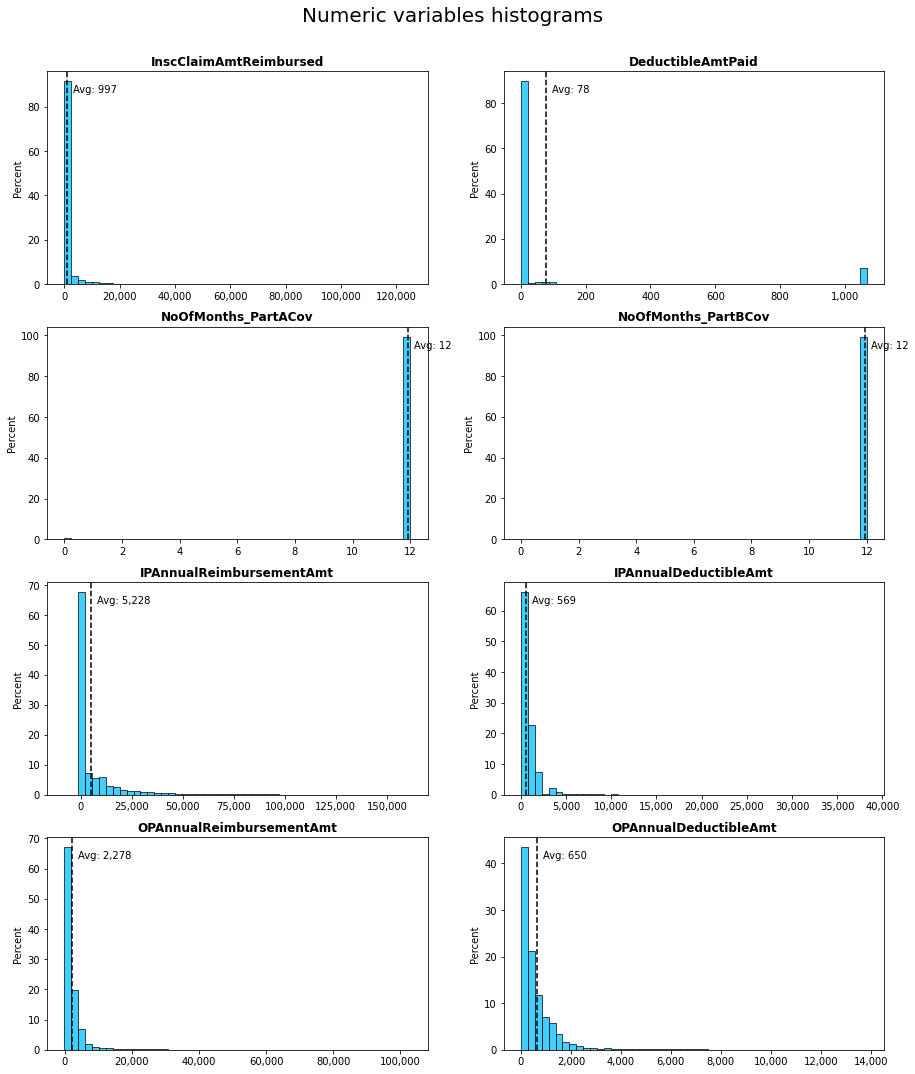

In [16]:
fig_num_of_cols = 2
fig_num_of_rows = ceil(len(num_vars)/fig_num_of_cols)

fig, axes = plt.subplots(fig_num_of_rows, fig_num_of_cols, figsize=(15, 18))
axes = axes.flatten()
fig.suptitle('Numeric variables histograms', fontsize=20, y=0.93)

def coma_formater(x, pos):
    return f'{x:,.0f}'

for i in range(len(num_vars)):
    sns.histplot(ax=axes[i], data=train_df, x=num_vars[i], kde=False, color='deepskyblue', bins = 50, stat='percent')
    axes[i].ticklabel_format(useOffset=False, style='plain')
    axes[i].set_xlabel('')
    axes[i].set_title(num_vars[i], fontweight="bold")
    
    var_mean = train_df[num_vars[i]].mean()
    axes[i].axvline(var_mean, color='k', linestyle='dashed', linewidth=1.5) # mean line
    annotation_y = axes[i].get_ylim()[1] * 0.9
    anotation_x = ((axes[i].get_xlim()[1] - axes[i].get_xlim()[0]) * 0.1 / 6.75) + var_mean # 6.75 is the length of the xaxis in pixels aprox
    

    if var_mean > 100000:
        axes[i].annotate(f'Avg: {var_mean/1000:,.0f} K', xy = (anotation_x, annotation_y))
    else:
        axes[i].annotate(f'Avg: {var_mean:,.0f}', (anotation_x, annotation_y))

    
    axes[i].xaxis.set_major_formatter(plt.FuncFormatter(coma_formater))
    


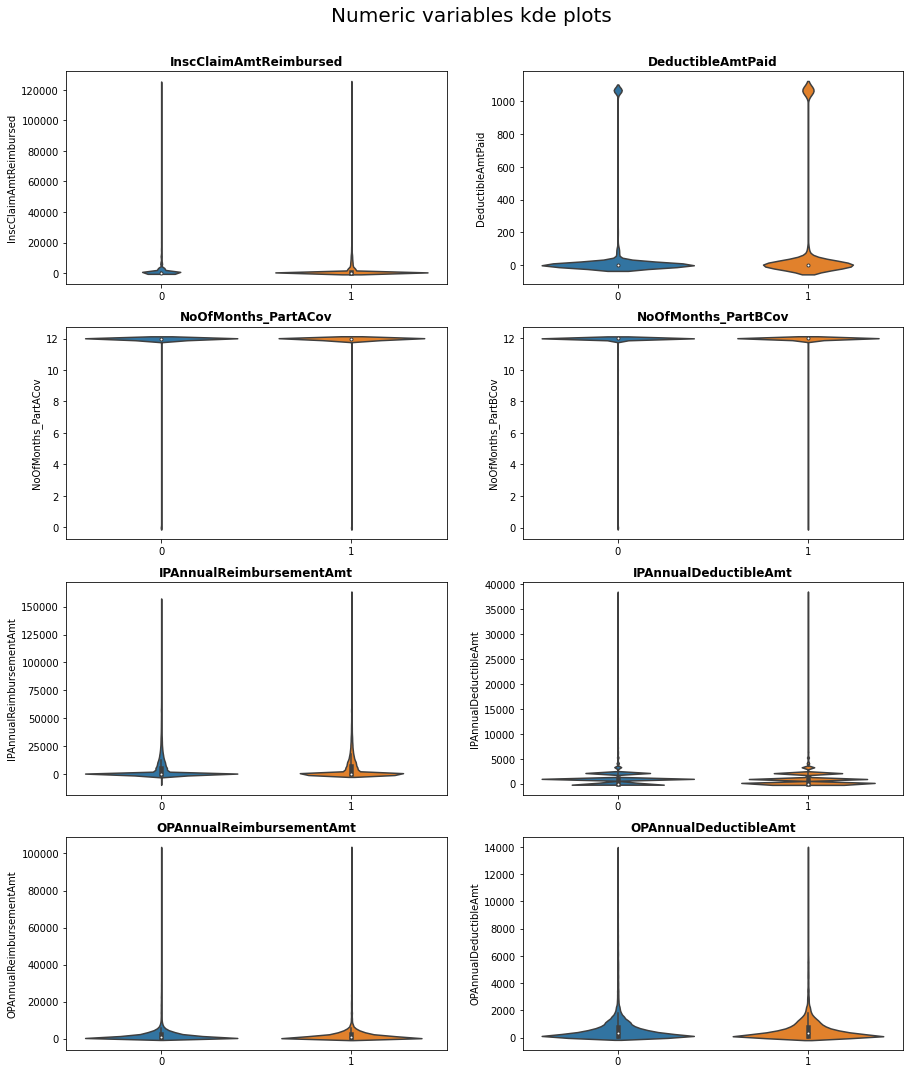

In [41]:
# Checking unique values for NoOfMonths_PartACov and NoOfMonths_PartBCov 
NoOfMonths_PartACov_counts =train_df[['NoOfMonths_PartACov']].value_counts().rename_axis('Month').reset_index(name='NoOfMonths_PartACov')
NoOfMonths_PartBCov_counts =train_df[['NoOfMonths_PartBCov']].value_counts().rename_axis('Month').reset_index(name='NoOfMonths_PartBCov')
NoOfMonths_PartACov_counts.merge(NoOfMonths_PartBCov_counts, on='Month').sort_values(by='Month')
# There are more values than just 12 so we will keep theese vars for now.

,Month,NoOfMonths_PartACov,NoOfMonths_PartBCov
1,0,2971,1979
11,1,13,48
9,2,16,41
10,3,16,73
5,4,55,60
8,5,30,126
2,6,116,728
6,7,44,139
3,8,100,142
12,9,13,242


### Boolean variables proportions

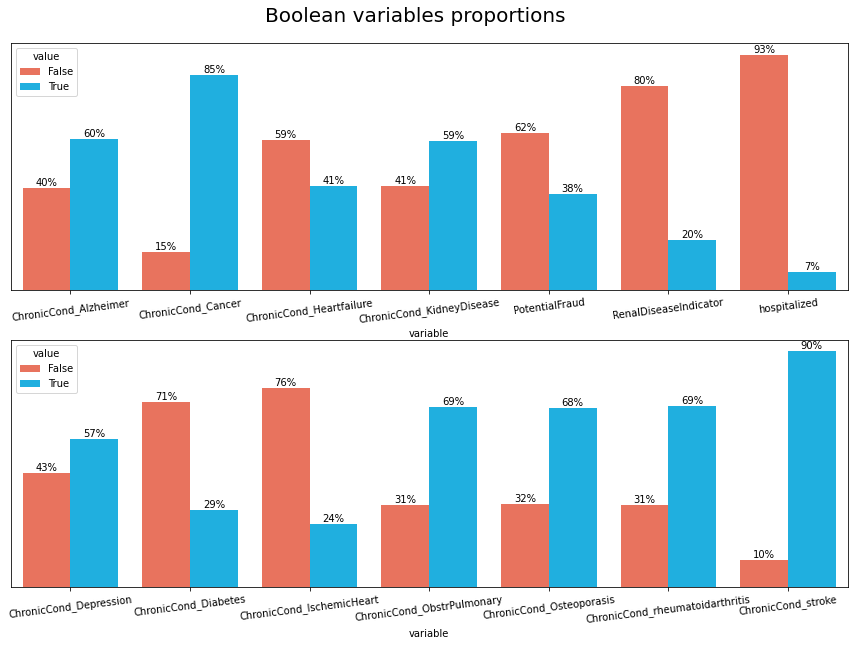

In [45]:
data_bol_tot_count = train_df[bool_vars].melt().groupby('variable').size().reset_index(name='totals') # total count per class for percentages
data_bol = train_df[bool_vars].melt().groupby(['variable', 'value']).size().reset_index(name='count').\
    merge(data_bol_tot_count, on='variable').assign(per = lambda x: x['count'] / x['totals'] * 100) # creating a df with % for each class

palette ={0: "tomato", 1: "deepskyblue"} # Creating custom palet for uor bolean vars.

fig_num_of_cols = 1
fig_num_of_rows = 2

fig, axes = plt.subplots(fig_num_of_rows, fig_num_of_cols, figsize=(15, 10))
axes = axes.flatten()
fig.suptitle('Boolean variables proportions', fontsize=20, y=0.93)

sns.barplot(ax=axes[0], x="variable", y = 'per', hue="value", data=data_bol.loc[data_bol['variable'].isin(bool_vars[0:7])], palette=palette)
sns.barplot(ax=axes[1], x="variable", y = 'per', hue="value", data=data_bol.loc[data_bol['variable'].isin(bool_vars[7:])], palette=palette)

axes[0].tick_params(axis='x', rotation=7)
axes[1].tick_params(axis='x', rotation=7)

for i in range(2):
    for container in axes[i].containers: # Adding labels
        axes[i].bar_label(container, fmt='%.f%%')

    axes[i].get_yaxis().set_visible(False) # Removing y axis


### Categorical variables proportions

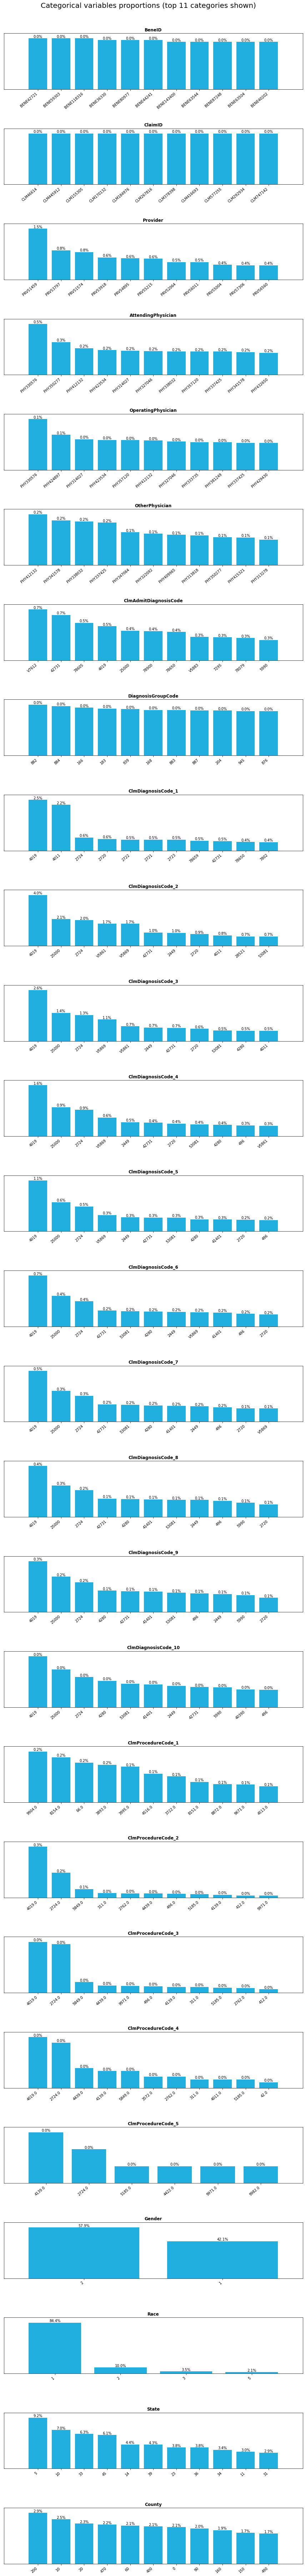

In [18]:
data_cat_tot_count = train_df[cat_vars].melt().groupby('variable').size().reset_index(name='totals') # total count per class for percentages
data_cat = train_df[cat_vars].melt().groupby(['variable', 'value']).size().reset_index(name='count').\
    merge(data_cat_tot_count, on='variable').assign(per = lambda x: x['count'] / x['totals'] * 100) # creating a df with % for each class

fig_num_of_cols = 1
fig_num_of_rows = ceil(len(cat_vars)/fig_num_of_cols)

fig, axes = plt.subplots(fig_num_of_rows, fig_num_of_cols, figsize=(15, 120))
axes = axes.flatten()
fig.suptitle('Categorical variables proportions (top 11 categories shown)', fontsize=20, y=0.93) 
fig.subplots_adjust(hspace=0.7, bottom=0.1, top=0.92)

for i in range(len(cat_vars)):
    var = cat_vars[i]
    axes[i] = sns.barplot(ax=axes[i], x='value', y = 'per', data=data_cat[data_cat['variable'] == var], 
                            color='deepskyblue', order = train_df[cat_vars[i]].value_counts().index[0:11])
    axes[i].set_xlabel('')
    axes[i].set_xticklabels(labels = axes[i].get_xticklabels(), rotation=40, ha='right')
    axes[i].set_title(cat_vars[i], fontweight="bold")
    axes[i].margins(0.1)

    for container in axes[i].containers: # Adding labels
        axes[i].bar_label(container, fmt='%.1f%%')

    axes[i].get_yaxis().set_visible(False) # Removing y axis

In [93]:
# To have a measure of cardinality we will calculate the % of uniqe values for each categorical var
train_df[cat_vars].melt().groupby('variable', as_index=False).nunique().sort_values(by='value', ascending = False)

# There are a lot of variables with very high cardinality. We will have to do something here.

,variable,value
2,ClaimID,558211
1,BeneID,138556
0,AttendingPhysician,82063
23,OtherPhysician,46457
22,OperatingPhysician,35315
4,ClmDiagnosisCode_1,10450
24,Provider,5410
6,ClmDiagnosisCode_2,5300
7,ClmDiagnosisCode_3,4756
8,ClmDiagnosisCode_4,4359


## Distributions Fraud vs Not Fraud

### numeric kde plots

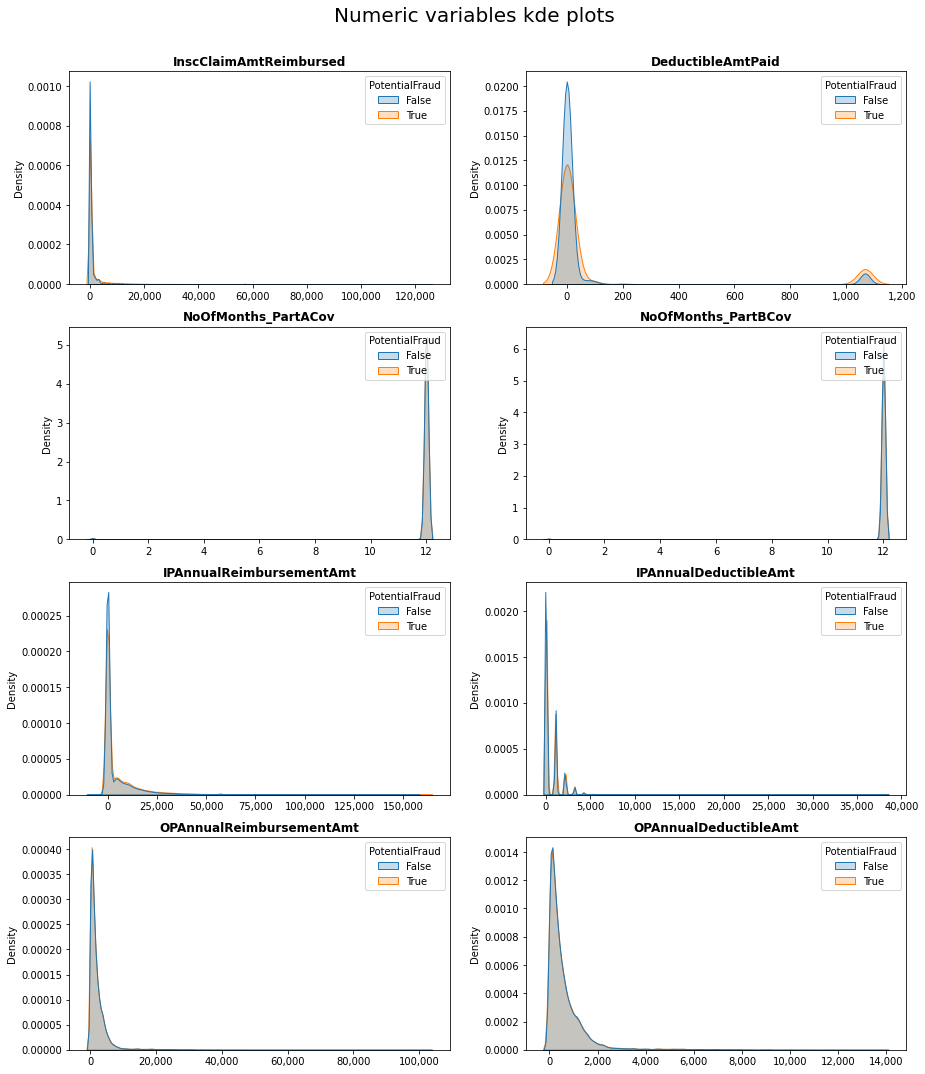

In [130]:
fig_num_of_cols = 2
fig_num_of_rows = ceil(len(num_vars)/fig_num_of_cols)

fig, axes = plt.subplots(fig_num_of_rows, fig_num_of_cols, figsize=(15, 18))
axes = axes.flatten()
fig.suptitle('Numeric variables kde plots', fontsize=20, y=0.93)

for i in range(len(num_vars)):
    sns.kdeplot(ax=axes[i], data=train_df, x=num_vars[i], hue='PotentialFraud', fill=True, common_norm=False) # common_norm so that sum of area of each hue sums to 1 and not both hue sum to 1.
    axes[i].set_xlabel('')
    axes[i].set_title(num_vars[i], fontweight="bold")
    axes[i].xaxis.set_major_formatter(plt.FuncFormatter(coma_formater))